Andrea Manzini, Lorenzo Lazzara, Martin Josifoski, Mazen Fouad A-wali Mahdi

# 1. Introduction and General Information

In this project, we analyze the LastFM dataset released in the framework of HetRec 2011 (http://ir.ii.uam.es/hetrec2011). This dataset contains an underlying social network, artists tags given by users, and user-artist listening count from a set of 1892 users and 17632 artists. Different type of files are given, describing the interactions between user-user, user-artist and tags. Our aim is to test whether friendship implies similar taste in music, in other words whether friends do tend to listen to the same music. 

We approach the problem in two different ways:
- We construst a network based on the similarity between artists and from it we try to infer user-user connections.
- We build a recommender system based on only the listening counts and then try to improve it using the underlying friendship network or the artist-artist similarity network.

In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import os.path
import networkx as nx
from scipy.sparse import csr_matrix
from Dataset import Dataset
from plots import *
import os
from helpers import *
%matplotlib inline

# Data Exploration

In this section we analyze our dataset that has the following structure: for each user there is a list of his/her favorite artists, each listened artist has a listening record denoting the listening times; for each artist there is a list of his/her genre, which is a list of tags given by users that have listened to the artist. In addition we have for each user a list of his friends.

The goal is to show the initial insights and the motivation, but the final processing is contained in the Dataset module whos' functions are called in each section to produce the dataset that is used throughout the notebook.

In [2]:
# Loading the data
data = Dataset()
data_folder = os.path.join('.','data')
ratings_path = os.path.join(data_folder,'user_artists.dat')
ratings = pd.read_csv(ratings_path, sep='\t', header=0, skipinitialspace=True)

In [3]:
data.artists.head()

,name,url,pictureURL
id,,,
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


### Tag analysis

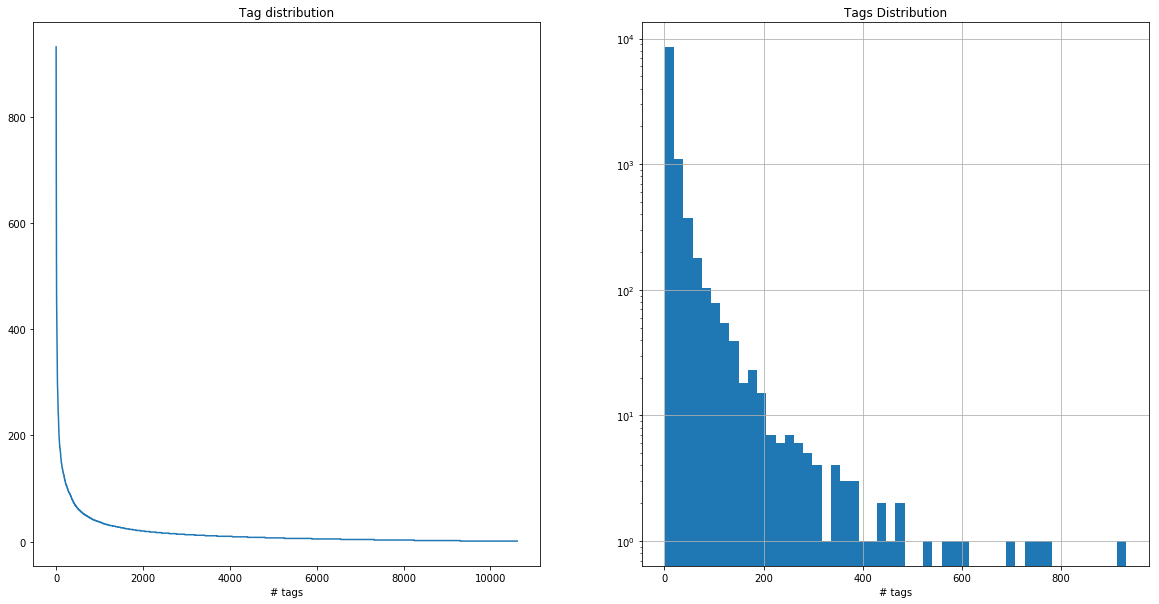

In [4]:
group = data.tags_assign[['artistID','tagID']].groupby(['artistID'])

group = group.size()
group.sort_values(ascending=False,inplace=True)

plot_tags_statistics(group)

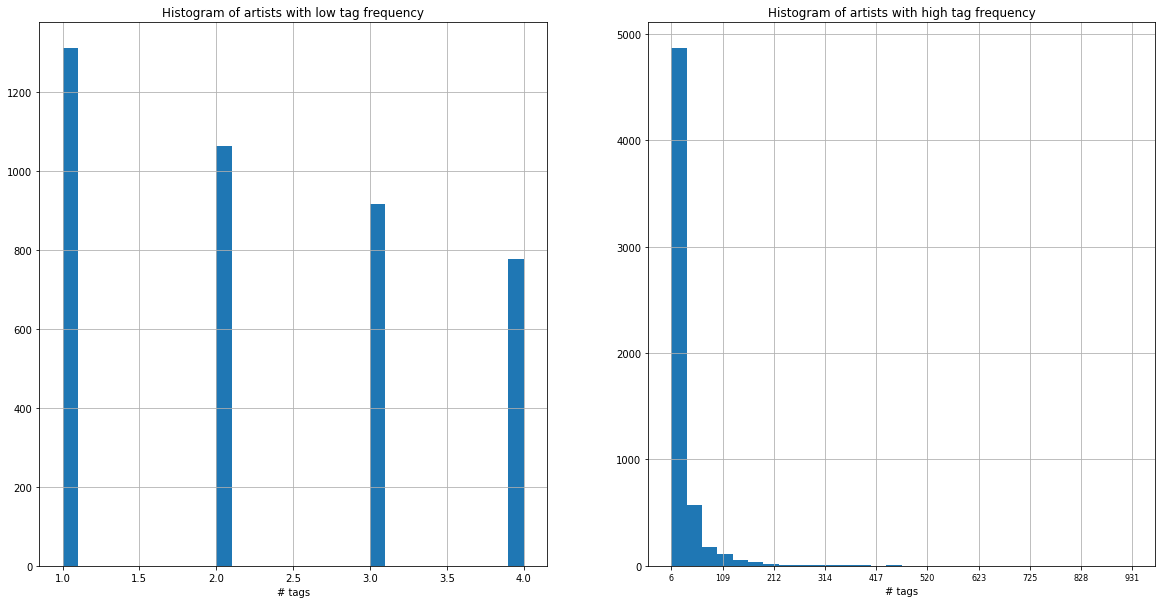

In [5]:
small = group.loc[group<5]
big = group.loc[group>5]

plot_separate_small_artist(small, big)

It can be observed that there are no artists with zero tags and most of the artists have more than 5 tags.

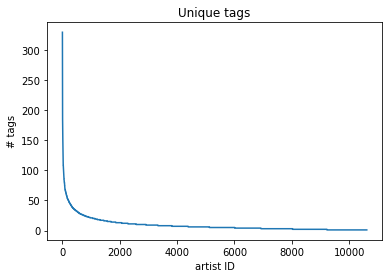

In [6]:
group = data.tags_assign[['artistID','tagID']].groupby(['artistID'])

group = group.nunique().tagID.sort_values(ascending=False)

plot_unique_tags(group)

From the above plot we can observe that for each artist we have a certain number of different tags but since LastFM tags are freeform a part of them can have the same meaning while written in different form, e.g., 90 -> 90' -> 90s or can have meaning that is identifiable only by the user itself.

### Listening count analysis

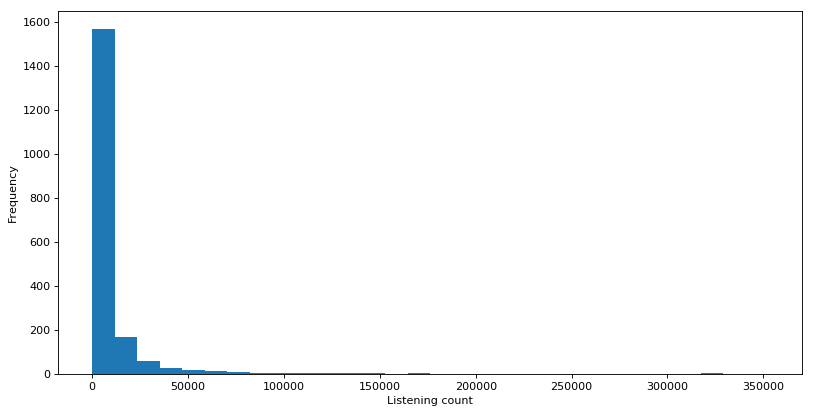

In [7]:
max_user_weight = data.ratings.groupby('userID').max()

plot_listenig_count_frequency(max_user_weight)

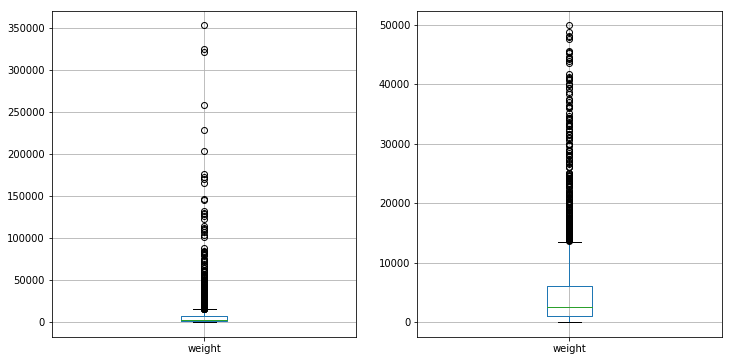

In [8]:
max_user_weight = data.ratings.groupby('userID').max()
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plt.subplot(1, 2, 1)
max_user_weight.boxplot(column='weight')
plt.subplot(1,2,2)
max_user_weight.loc[max_user_weight['weight']<=50000].boxplot(column='weight');

We can see from the plot above that most of the users have a maximum listening count of less than 50,000, while some of them are significantly higher. Observing such high listening counts for 1 artist seems highly unprobable and such activity looks suspicious, possibly motivated by commercial purposes, hence excluded.

In [9]:
print("The number of users with less than a maximum of 50,000 listening count:",\
      len(max_user_weight.loc[max_user_weight['weight']<=50000]))

percentage = len(max_user_weight.loc[max_user_weight['weight']<=50000])/ len(max_user_weight)*100
print("Percentage of total users:", \
     percentage ,"%")

The number of users with less than a maximum of 50,000 listening count: 1827
Percentage of total users: 96.87168610816543 %


A function that prunes the listening counts.

In [10]:
data.prune_ratings()

72  users dropped in weights pruning


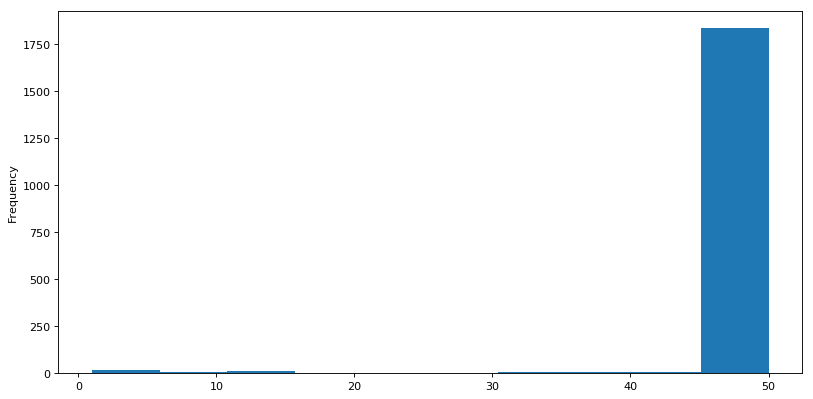

In [11]:
number_user_artist =ratings.groupby('userID').nunique().artistID.to_frame()

plot_artist_per_user(number_user_artist)

The plot shows that most of the users have around 50 artist connections. We decided to remove the users who listened to less than 10 different artists. (The motivation to keep all the users with artist connections above 10 will be shown later, since the distribution of artists changes slightly after a small reduction in the artist-artist similarity network construction.) 

### User-User network

In this section we analyze the lastFm social network.

In [12]:
#G is the total graph with all users ,except the one already pruned, and multiple component
G = nx.Graph(data.build_friend_friend())

print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

My network has 1820 nodes.
My network has 11218 edges.


In [13]:
nx.is_connected(G)

False

In [14]:
connected_components = nx.connected_components(G)
for i, subgraph in enumerate(sorted(connected_components, key = len, reverse=True)):
    print("Subgraph {} has {} nodes" .format(i, len(subgraph)))

Subgraph 0 has 1747 nodes
Subgraph 1 has 7 nodes
Subgraph 2 has 4 nodes
Subgraph 3 has 3 nodes
Subgraph 4 has 3 nodes
Subgraph 5 has 3 nodes
Subgraph 6 has 3 nodes
Subgraph 7 has 3 nodes
Subgraph 8 has 2 nodes
Subgraph 9 has 2 nodes
Subgraph 10 has 2 nodes
Subgraph 11 has 2 nodes
Subgraph 12 has 2 nodes
Subgraph 13 has 2 nodes
Subgraph 14 has 2 nodes
Subgraph 15 has 2 nodes
Subgraph 16 has 2 nodes
Subgraph 17 has 2 nodes
Subgraph 18 has 2 nodes
Subgraph 19 has 2 nodes
Subgraph 20 has 2 nodes
Subgraph 21 has 1 nodes
Subgraph 22 has 1 nodes
Subgraph 23 has 1 nodes
Subgraph 24 has 1 nodes
Subgraph 25 has 1 nodes
Subgraph 26 has 1 nodes
Subgraph 27 has 1 nodes
Subgraph 28 has 1 nodes
Subgraph 29 has 1 nodes
Subgraph 30 has 1 nodes
Subgraph 31 has 1 nodes
Subgraph 32 has 1 nodes
Subgraph 33 has 1 nodes
Subgraph 34 has 1 nodes
Subgraph 35 has 1 nodes
Subgraph 36 has 1 nodes
Subgraph 37 has 1 nodes
Subgraph 38 has 1 nodes
Subgraph 39 has 1 nodes
Subgraph 40 has 1 nodes
Subgraph 41 has 1 nodes

The User social network graph is composed of 29 disconnected subgraphs. Fortunately most of the user (~ 97.5 %) are inside one subgraph, so we can discard all the others in order to have a connected graph.

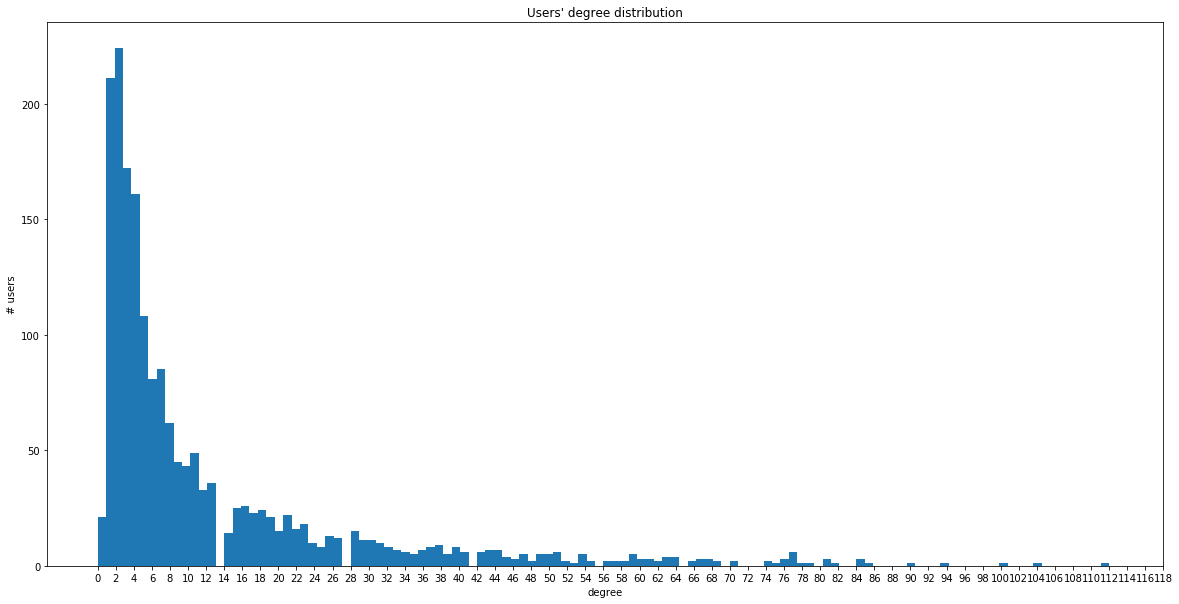

In [15]:
degree_distribution(G.degree())

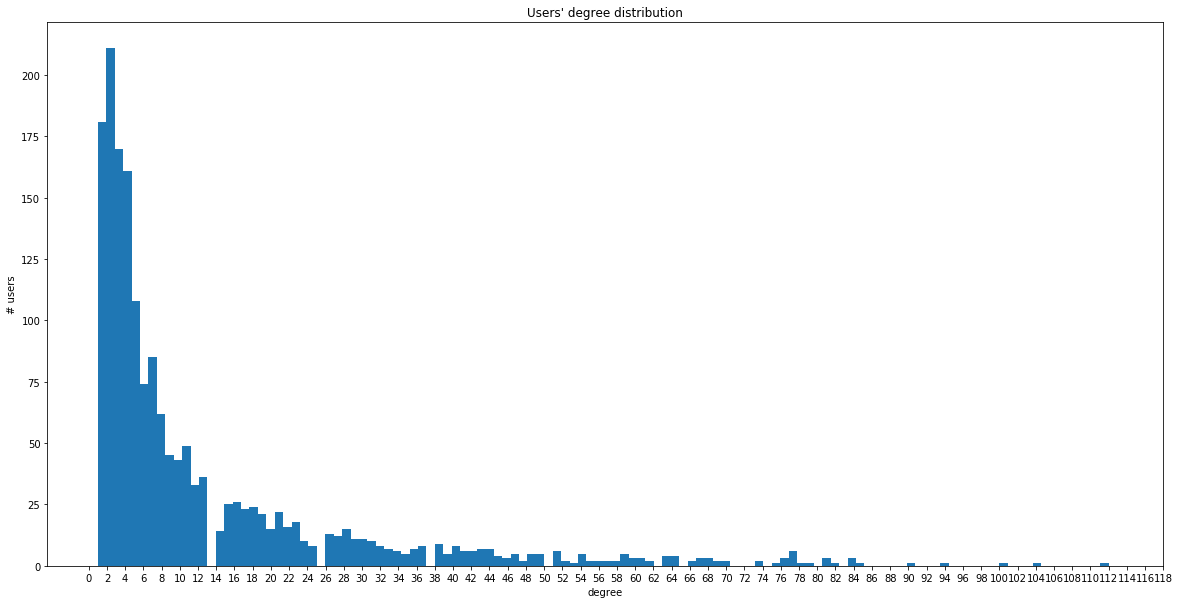

My network has 1747 nodes.
My network has 11166 edges.


In [16]:
graphs = list(nx.connected_component_subgraphs(G))
#giant component is the graph which contains most of the users
giant_component = graphs[0]

degree_distribution(giant_component.degree())

print('My network has {} nodes.'.format(len(giant_component.nodes())))
print('My network has {} edges.'.format(giant_component.size()))

As we can observe the degree distribution is mostly unchanged, we only have a little decrease of the number of user with very small connections since the subgraphs we deleted were composed of few users. The function below updates the dataset by reducing the dataset to its largest connected component.

In [17]:
data.prune_friends()

73  users dropped in friendship pruning


### Weight Normalization
We need to build a similarity graph for collaborative filtering. We need to understand which artists users listen to and not necessarely how much. Even though taking into account the absolute value of listening counts could have been a measure of how much we can trust a user preferences, we decided to normalize separately for each user in order to keep the weights simple and clear. In particular we model the normalized weight as the ratio the listening count and the biggest listening count for each user. Thus, all the weights of a user are less or equal to 1.

In [18]:
data.normalize_weights()

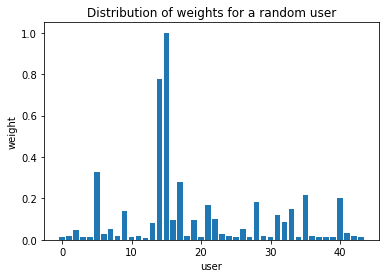

In [19]:
# Plot distribution of weights for a random user
user_weight_distribution(data.ratings, seed=1)

# 1. Friendship inference from music taste

These are the steps we followed to build the user-user comparison network:
* Construct an artist similarity graph and connect the users to artists using the normalized listening count.


* For each user consider all the possible direct paths  $u_i \rightarrow a_k \rightarrow u_j$ and 3-hop paths $u_i \rightarrow a_k \rightarrow a_l \rightarrow u_j$ where the $u_i \rightarrow a_k$ and $a_l \rightarrow u_j$ are weighted with the respective normalized weight (call them $C_{ik}$ and $C_{jl}$) while the weight between the two artists represents the strength of the similarity taken from the constructed similiraty graph (call it $S_{kl}$).


* Add an edge between each pair $u_i$ and $u_j$ with a weight equal to: $F_{ij} = \sum\limits_{k,l \in \Omega} S_{kl}\min\{C_{ik}, C_{jl}\} + \sum\limits_{k \in \Theta}\min\{C_{ik}, C_{jk}\}$ where $\Omega$ is the set of all artists that are similar to each other out of which one is connected to i and one is connected to j, and  $\Theta$ is the set of all artists that are connected to both users.


* To inspect the connection between the taste in music (listening counts) and the friendships in the underlined network, a random network following the same degree distribution of the artist  similarity network is constructed and the user-user network generated as previously described from this random network is compared to the output generated from the meaningful artist similarity network. 

This [article](https://musicalist.hypotheses.org/236) describes the reason why LastFM enforces their tagging policy and why the tags generated in that way are a meaningful source of information.
Since the data exploration of the tags dataset showed that all of the artists have been tagged we were motivated to use the tags assigned to each artist to infer similarity between them. Before acting, it was noticed that their api offers a function that retrieves similar artists for a given mbid unique code that identifies an artist. All the details are contained in the api notebook.

## Creating the friendship network

In [20]:
data = Dataset()
data.prune_ratings()
data.prune_friends()
data.normalize_weights()

72  users dropped in weights pruning
73  users dropped in friendship pruning


In [21]:
friendship = data.build_friend_friend()

Checking symmetry of the friendship matrix.

In [22]:
np.nonzero(friendship-friendship.transpose())

(array([], dtype=int64), array([], dtype=int64))

In [23]:
friendship.shape

(1747, 1747)

Creating the friendship graph.

In [24]:
friendship_graph = nx.Graph(friendship)

## Creating the artist-artist network

In [25]:
artist_artist_matrix = data.build_art_art()

Checking symmetry of the friendship matrix.

In [26]:
np.nonzero(artist_artist_matrix-artist_artist_matrix.transpose())

(array([], dtype=int64), array([], dtype=int64))

In [27]:
artist_artist_matrix.shape

(13106, 13106)

Creating the artist-artist graph.

In [28]:
artist_artist_graph = nx.Graph(artist_artist_matrix)

## Creating the user-artist network

In [29]:
user_artist_matrix = pickle.load(open('data/art_user.pickle', 'rb'))
user_artist_matrix = csr_matrix.todense(user_artist_matrix)
user_artist_matrix = np.array(user_artist_matrix.T)

In [30]:
user_artist_matrix.shape

(1747, 13106)

## Inferring the New User-User Network

According to the artist similarity network and the user-artist listening counts, friendship between users is infered as describe in the beggining of the section.

In [31]:
generated_user_user_matrix = generate_user_user_matrix_from_artist_artist_matrix(user_artist_matrix, artist_artist_matrix)
generated_user_user_graph = nx.Graph(generated_user_user_matrix)

For comparison a random network that follows the degree distribution of the artist similarity network is generated.

In [32]:
artist_artist_random_graph, stub_pairs = greedy_configuration(artist_artist_graph)
artist_artist_random_matrix = np.array(csr_matrix.todense(nx.adjacency_matrix(artist_artist_random_graph)))

We check whether any stubs left unconnected (we shouldn't have any if the configuration works correctly).

In [33]:
sum(stub_pairs.values()) # should be equal to zero if configuration was successful

0

Analogously we infer user friendships, based on the random network.

In [34]:
generated_user_user_matrix_from_random_aa = generate_user_user_matrix_from_artist_artist_matrix(user_artist_matrix, artist_artist_random_matrix)
generated_user_user_graph_from_random_aa = nx.Graph(generated_user_user_matrix_from_random_aa)

At this point we have a friendship network that is generated based on the similarity between artists, and another one generated based on a random network. We want to test whether users who tend to listen to similar artists and hence have similar taste of music are friends in the social network, compared to the scenario that their music taste is irrelevant for infering friendships between users.

In [35]:
print("The number of friendships in the underlying social network is %d." % (int(friendship.sum()/2)))

The number of friendships in the underlying social network is 11166.


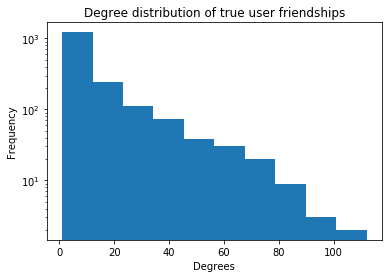

In [36]:
plt.hist(list(dict(friendship_graph.degree()).values()), log=True);
plt.title('Degree distribution of true user friendships');
plt.xlabel('Degrees');
plt.ylabel('Frequency');

In [37]:
threshold = 0.4
reduced_matrix = np.zeros(generated_user_user_matrix.shape)
reduced_matrix[generated_user_user_matrix > threshold] = 1
reduced_matrix[generated_user_user_matrix <= threshold] = 0
reduced_graph = nx.Graph(reduced_matrix)
compare_networks(friendship_graph, reduced_graph)

The total number of detected links is 1384.
The total number of not detected links is 9782.


In [38]:
print("The number of infered friendships is %d." % int((generated_user_user_matrix.flatten()[generated_user_user_matrix.flatten() > threshold].shape)[0]/2))

The number of infered friendships is 13394.


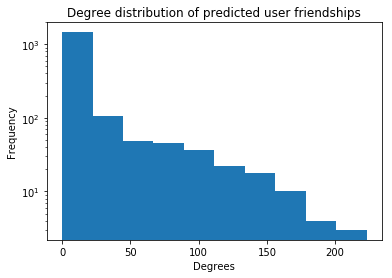

In [39]:
plt.hist(list(dict(reduced_graph.degree()).values()), log=True);
plt.title('Degree distribution of predicted user friendships');
plt.xlabel('Degrees');
plt.ylabel('Frequency');

In [40]:
threshold = 0.3
reduced_matrix[generated_user_user_matrix_from_random_aa > threshold] = 1
reduced_matrix[generated_user_user_matrix_from_random_aa <= threshold] = 0
reduced_graph = nx.Graph(reduced_matrix)
compare_networks(friendship_graph, reduced_graph)

The total number of detected links is 1579.
The total number of not detected links is 9587.


In [41]:
print("The number of infered friendships is %d." % int((generated_user_user_matrix_from_random_aa.flatten()[generated_user_user_matrix_from_random_aa.flatten() > threshold].shape)[0]/2))

The number of infered friendships is 12626.


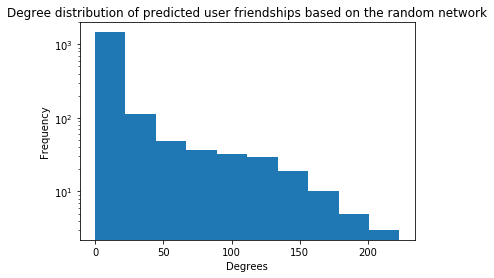

In [42]:
plt.hist(list(dict(reduced_graph.degree()).values()), log=True);
plt.title('Degree distribution of predicted user friendships based on the random network');
plt.xlabel('Degrees');
plt.ylabel('Frequency');

**Based on the results above, we can deduce that existence of friendship does not indicate same taste of music, since the inference based on the similarity of favourite artists between users had comparable, even slightly inferior results to the inferences based on a random network (when the taste in music is not taken into consideration at all).**

# 2. Recommender System

In order to evaluate the artists network and users network information about users' preferencies, we tried to exploit them in a reccomender system, to see if they could give some improvements. This would allow us also to get another point of view over the user-user network nature. The data was splitted in 6 folds and cross validation was done to evaluate prediction scores. The code we used is contained in recommender.py source file.

## Smooth Matrix Factorization

#### Introduction:
We tried to implement an algorithm that uses the implicit ratings extracted by the user/artist network structure in an efficient way. We starting from one of the most famous recommender algorithm which became famous during the netflix prize. It is usually appelled as SVD and it is a matrix factorization extended with user and items baselines learning [Koren, Factorization meets the neighborhood: a multifaceted collaborative filtering model, 2008]. We sobstitute the traditional regularized term ($L_2$ norm of all the parameters) with a term which penalizes the solution that are not smooth over the given graph. The reason for this is that we expect similar artists to receive similar ratings from the same user and on the other side we expect similar users to give similar ratings to similar artists. Thus the predicted ratings should be smooth over both the graphs.

We will derive the SGD update of the algorithm only in the case of a smoothing over the user-user network. In order to get the formulas for the artist-artist network we just need to swap users with artists. 

#### Notation:
* $F$:  loss function
* $r_{ui}$: real ratings(weight) given by user $u$ to artist $i$
* $\hat{r_{ui}}$: estimated ratings(weight) given by user $u$ to artist $i$
* $b_u$:  baseline of the user $u$
* $b_i$:  baseline of the artist $i$
* $\mu$:  global mean of ratings
* $w_u$:  vector of features associated with user $u$
* $z_i$:  vector of features associated with artist $i$
* $L$  :  laplacian matrix of the user network
* $|U|$:  total number of users in the network

#### Formulas:
$$ r_{ui} = \mu + b_u + b_i + w_u^T z_i  $$

$$ F_i = ||R_{:i}-\hat{R_{:i}}||^2 + \alpha R_{:i}^T L \hat{R_{:i}}$$

$$ F_{ui} = (r_{ui} - \hat{r_{ui}})^2 + \alpha \sum_{k=1}^{|U|} L_{uk} \hat{r_{ui}} \hat{r_{ki}} $$

$$ \frac{\partial{F_{ui}}}{\partial{b_u}} = -2(r_{ui} - \hat{r_{ui}}) + \alpha \sum_{k=1}^{|U|} L_{uk} (\hat{r_{ki}} + \hat{r_{ui}}) $$

$$ \frac{\partial{F_{ui}}}{\partial{b_i}} = -2(r_{ui} - \hat{r_{ui}}) + \alpha \sum_{k=1}^{|U|} L_{uk} (\hat{r_{ki}} + \hat{r_{ui}}) $$

$$ \frac{\partial{F_{ui}}}{\partial{w_u}} = -2(r_{ui} - \hat{r_{ui}})z_i + \alpha z_i \sum_{k=1}^{|U|} L_{uk} (\hat{r_{ki}} + \hat{r_{ui}}) $$

$$ \frac{\partial{F_{ui}}}{\partial{z_i}} = -2(r_{ui} - \hat{r_{ui}})w_u + \alpha \sum_{k=1}^{|U|} L_{uk} (w_u \hat{r_{ki}} + w_k \hat{r_{ui}}) $$

From this point the SGD update rule can be easily obtained using the gradient direction. Also a costant $\gamma$ called learning rate should be added in front of the gradient.

#### Implementation
The algorithm was implemented using as framework the surprise library [https://github.com/NicolasHug/Surprise] which is specifically design for recommendations. We link here a GitHub fork that was customized to include the new algorithm [https://github.com/manzo94/Surprise/tree/laplacian_smooth]. We also included it in the submission folder. This customized library must be installed in order to run the code. We expected the smooth matrix factorization to be very computationl heavy, so we decided to implement it using the Cython compiler [https://github.com/cython/cython]. This compiler together with a numpy wrapper and a specifically designed code can achieve high speed performances. In particular we tried to follow some rules to get  more improvements:
* For the variables we use Cython fixed types instead of Python dynamic types.
* Indexing of numpy arrays is done without slicing, inside for loops over the single elements.
* We use memoization when possible, avoiding to compute the same quantities more than once.

#### Results
We present the results of three different scenarios:  
1) Smooth MF over artist-artist network  
2) Smooth MF over social network  
3) Classic SVD with regularizer  

In particular we show plots of the RMSE score obtained on a 6 folds cross validation over the regularizer coefficient ($\alpha$ in the smooth MF) and the best score obtained for each method. As a reference we also report the score obtained using the global mean as a constant estimator (all predictions equal to the global mean).

RMSE on smooth MF over artists:  0.9067
RMSE on smooth MF over users:  0.9074
RMSE on classic SVD:  0.9068
RMSE on global mean estimator:  1.0721


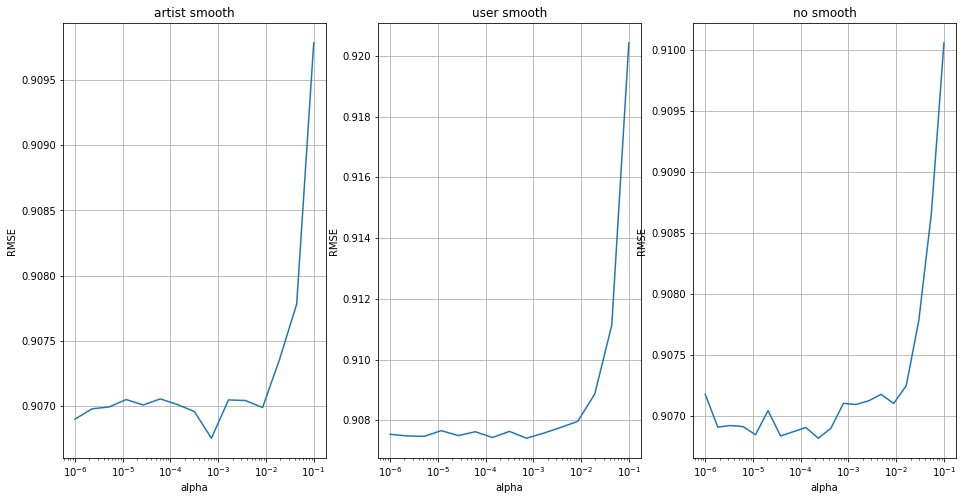

In [43]:
plot_rmse()

#### Interpretation:
As the network comparison suggested, with respect to the classical SVD, we expect this algorithm to work very well on the artist network and much worse on the social network. This is because we observed before that the social network is not informative about users' preferences. Even though the plots slightly goes into the expected direction, we think that the deviation of the RMSE in the three cases is too small to confirm our intuitions. The observed behaviour may be caused by one the following reasons:
* There is a mistake in the smooth MF implementation, so that the smoothing regularizer does not work well
* The artist network is not so informative as we demonstrated in 1.
* This particular algorithm (with also baseline terms) can't benefit from smoothing regularizers